In [1]:
!pip install lazypredict

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import keras.backend as K

from lazypredict.Supervised import LazyClassifier


/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [2]:
train = pd.read_csv('/kaggle/input/titanic/train.csv').copy()
test = pd.read_csv('/kaggle/input/titanic/test.csv').copy()

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,PC 17599,71.28,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.05,NaN,S


In [4]:
train.shape

(891, 12)

In [5]:
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

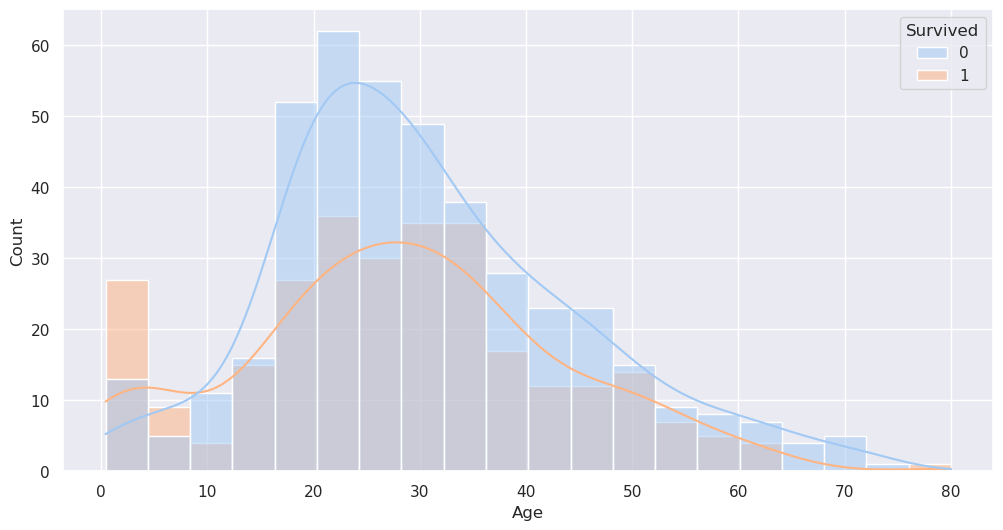

In [6]:
PLOT_SIZE = (12, 6)
sns.set_theme(palette="pastel")
plt.figure(figsize=PLOT_SIZE)
h = sns.histplot(data=train, x="Age", hue="Survived", kde=True)

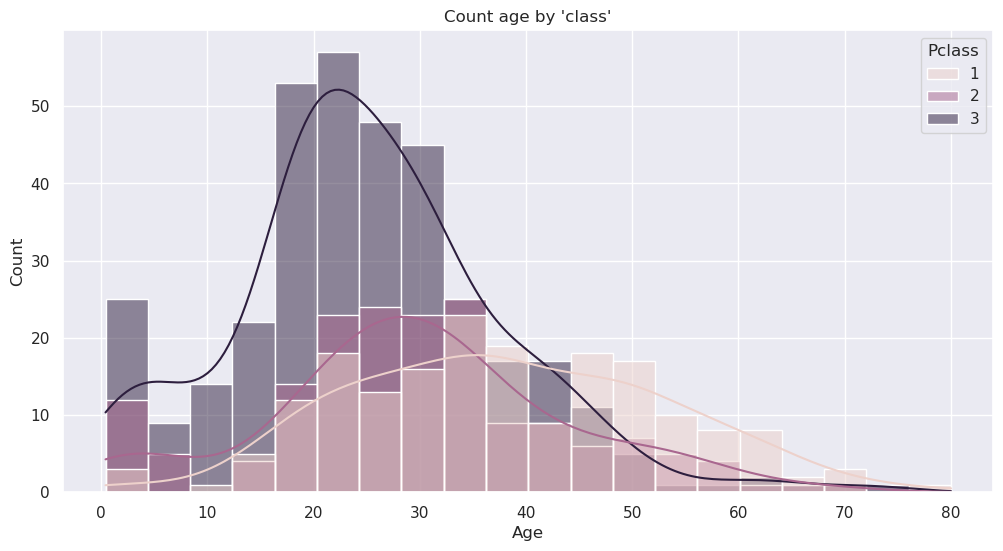

In [7]:
plt.figure(figsize=PLOT_SIZE)
h = sns.histplot(data=train, x="Age", hue="Pclass", kde=True).set_title("Count age by 'class'")

In [8]:
train.groupby(["Pclass"])["PassengerId"].agg(["count"]).rename(columns={"count":"Number"})

,Number
Pclass,
1,216
2,184
3,491


In [9]:
train.groupby(["Sex","Pclass"])["Pclass"].agg(["count"])

count
Sex    Pclass       
female 1          94
       2          76
       3         144
male   1         122
       2         108
       3         347

In [10]:
classes_grouped = train.groupby(["Pclass"])["Survived"].agg(["count", "sum"])
classes_grouped["sub"] = classes_grouped["count"] - classes_grouped["sum"]

classes_grouped.rename(columns={"count" : "All",
                                "sum" : "Survived",
                                "sub" : "Dead"})

,All,Survived,Dead
Pclass,,,
1,216,136,80
2,184,87,97
3,491,119,372


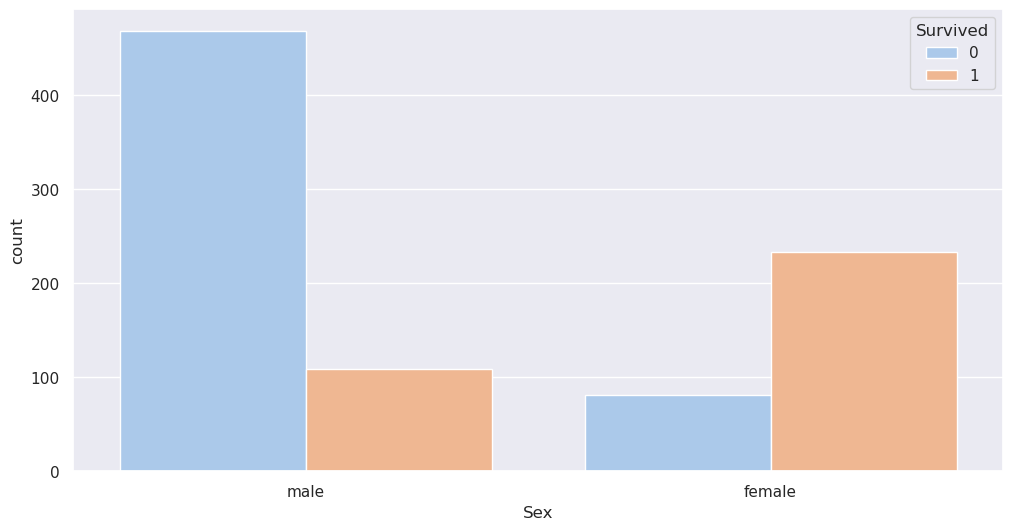

In [11]:
plt.figure(figsize=PLOT_SIZE)
c = sns.countplot(data=train, x="Sex", hue="Survived")

Predprocesiranje

In [12]:
def get_title(text):
    for word in text.split():
        if "." in word:
            return word[:-1]
        
        
train["Title"] = train["Name"].map(get_title)
train["Title"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

In [13]:
grouped_titles_sum = train.groupby(["Title"])["Survived"].agg(["count", "sum"])
grouped_titles_sum["Dead"] = grouped_titles_sum["count"] - grouped_titles_sum["sum"]

grouped_titles_sum.rename(columns={"sum" : "Survived",
                                   "count" : "All"}).sort_values(by="All", ascending=False)

,All,Survived,Dead
Title,,,
Mr,517,81,436
Miss,182,127,55
Mrs,125,99,26
Master,40,23,17
Dr,7,3,4
Rev,6,0,6
Major,2,1,1
Col,2,1,1
Mlle,2,2,0


In [14]:
titles = ["Miss", "Mrs", "Mr", "Master"]
train["Title"] = train["Title"].map(lambda x: x if x in titles else "Other")

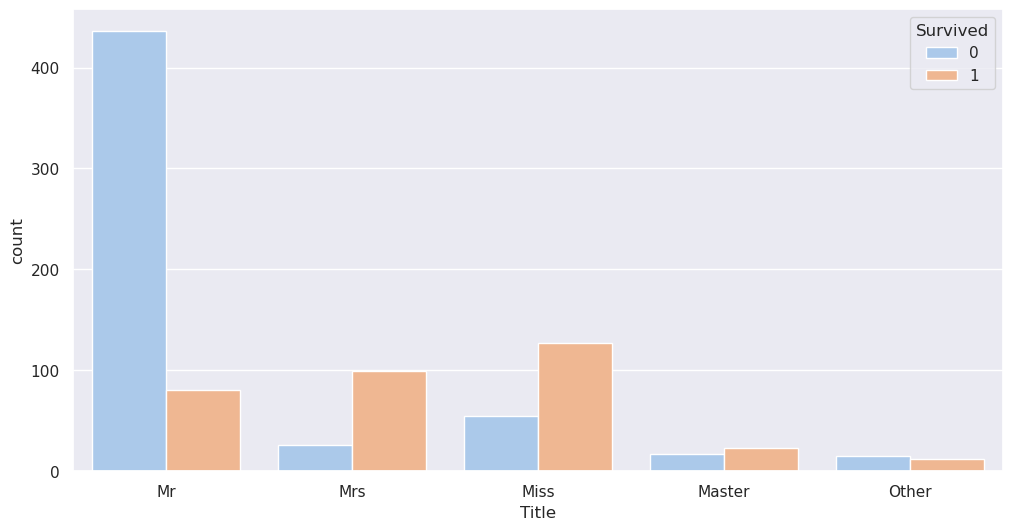

In [15]:
plt.figure(figsize=PLOT_SIZE)
c = sns.countplot(data=train, x="Title", hue="Survived")

In [16]:
# Parch == Parents and children (indicator of family members)
train["HasFamily"] = train["Parch"].map(lambda x: 1 if x != 0 else 0)
# sSibsp == Siblings and spouse (again indicates family members)
train["HasSib"] = train["SibSp"].map(lambda x: 1 if x != 0 else 0)

In [17]:
train["FarePerFamily"] = train["Fare"] / (train["Parch"]+1)
train["FarePerSib"] = train["Fare"] / (train["SibSp"]+1)

In [18]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,HasFamily,HasSib,FarePerFamily,FarePerSib
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,S,Mr,0,1,7.25,3.62
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,PC 17599,71.28,C85,C,Mrs,0,1,71.28,35.64
2,3,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,NaN,S,Miss,0,0,7.92,7.92
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,C123,S,Mrs,0,1,53.10,26.55
4,5,0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.05,NaN,S,Mr,0,0,8.05,8.05


In [19]:
del train["Cabin"]

In [20]:
train["Age"] = train["Age"].fillna(train["Age"].median())

In [21]:
train = train.dropna()

In [22]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,HasFamily,HasSib,FarePerFamily,FarePerSib
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,S,Mr,0,1,7.25,3.62
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,PC 17599,71.28,C,Mrs,0,1,71.28,35.64
2,3,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,S,Miss,0,0,7.92,7.92
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,S,Mrs,0,1,53.10,26.55
4,5,0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.05,S,Mr,0,0,8.05,8.05


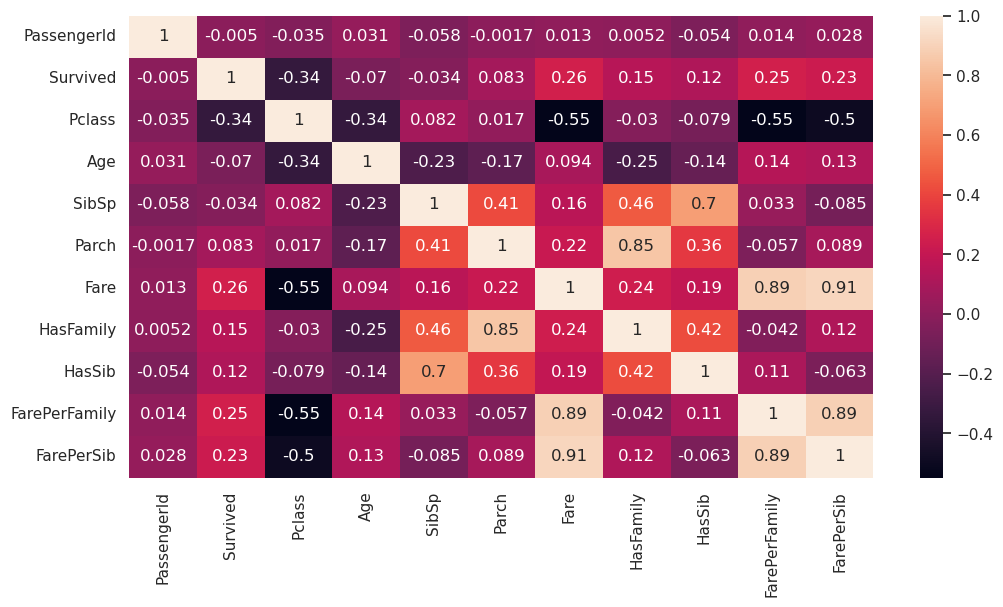

In [23]:
plt.figure(figsize=PLOT_SIZE)
h = sns.heatmap(train.corr(), annot=True)

In [24]:
lab_encoder_sex = LabelEncoder()
lab_encoder_embarked = LabelEncoder()
lab_encoder_title = LabelEncoder()
train.loc[:,"Sex"] = lab_encoder_sex.fit_transform(train["Sex"])
train.loc[:,"Embarked"] = lab_encoder_embarked.fit_transform(train["Embarked"])
train.loc[:,"Title"] = lab_encoder_title.fit_transform(train["Title"])

In [25]:
label = train["Survived"]
train = train.drop(["PassengerId", "Survived", "Name", "Ticket"], axis=1)

In [26]:
train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,HasFamily,HasSib,FarePerFamily,FarePerSib
0,3,1,22.00,1,0,7.25,2,2,0,1,7.25,3.62
1,1,0,38.00,1,0,71.28,0,3,0,1,71.28,35.64
2,3,0,26.00,0,0,7.92,2,1,0,0,7.92,7.92
3,1,0,35.00,1,0,53.10,2,3,0,1,53.10,26.55
4,3,1,35.00,0,0,8.05,2,2,0,0,8.05,8.05


In [27]:
X_train, X_test, y_train, y_test = train_test_split(train, label, test_size=0.3)

In [28]:
scaler = StandardScaler()
minmax_scaler = MinMaxScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

In [29]:
reg = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(X_train_s, X_test_s, y_train, y_test)

100%|██████████| 29/29 [00:01<00:00, 19.69it/s]


In [30]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
DecisionTreeClassifier,0.82,0.78,0.78,0.81,0.01
RandomForestClassifier,0.81,0.78,0.78,0.80,0.20
ExtraTreeClassifier,0.80,0.78,0.78,0.80,0.01
BaggingClassifier,0.81,0.77,0.77,0.80,0.04
AdaBoostClassifier,0.80,0.77,0.77,0.80,0.12
SVC,0.80,0.77,0.77,0.80,0.03
NuSVC,0.79,0.76,0.76,0.79,0.04
LogisticRegression,0.79,0.76,0.76,0.79,0.02
LGBMClassifier,0.79,0.76,0.76,0.79,0.11


# DNN

In [31]:
import tensorflow as tf
from tensorflow import keras

In [32]:
keras_model = keras.models.Sequential([
    
    keras.layers.Input(shape=[12]),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dense(16, activation="relu"),      
    keras.layers.Dense(8, activation="relu"),     
    keras.layers.Dense(1, activation="sigmoid")
])

In [33]:
keras_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                416       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,089
Trainable params: 1,089
Non-trainable params: 0
_________________________________________________________________


In [34]:
keras_model.compile(
        optimizer=tf.keras.optimizers.RMSprop(),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

In [35]:
hist = keras_model.fit(X_train_s, y_train, 
                       validation_split=0.2,
                       epochs=4)

Epoch 1/4
16/16 [==============================] - 3s 30ms/step - loss: 0.6970 - accuracy: 0.5412 - val_loss: 0.6779 - val_accuracy: 0.6320
Epoch 2/4
16/16 [==============================] - 0s 5ms/step - loss: 0.6655 - accuracy: 0.7042 - val_loss: 0.6586 - val_accuracy: 0.7520
Epoch 3/4
16/16 [==============================] - 0s 6ms/step - loss: 0.6411 - accuracy: 0.7666 - val_loss: 0.6385 - val_accuracy: 0.7840
Epoch 4/4
16/16 [==============================] - 0s 5ms/step - loss: 0.6164 - accuracy: 0.7887 - val_loss: 0.6152 - val_accuracy: 0.7920


<AxesSubplot:>

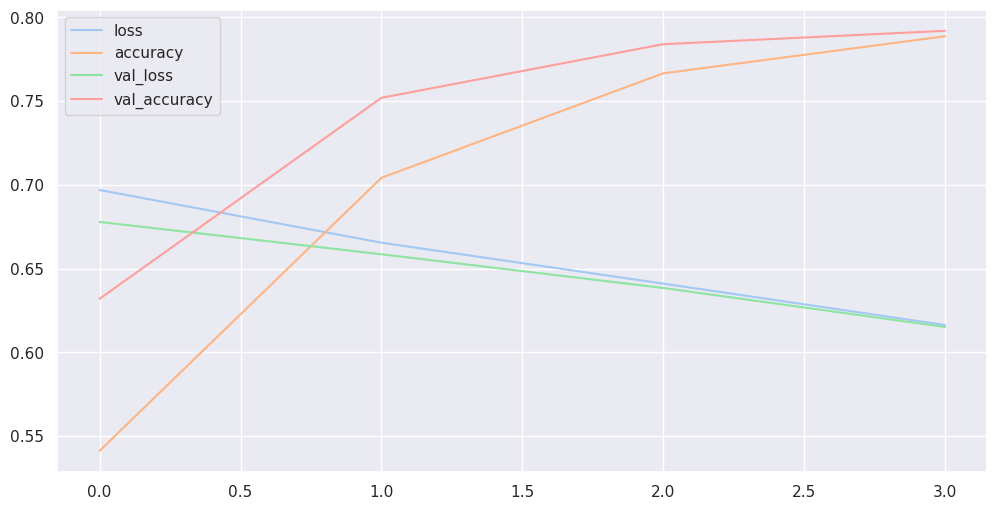

In [36]:
pd.DataFrame(hist.history).plot(figsize=PLOT_SIZE)

In [37]:
keras_model.evaluate(X_test_s, y_test)

9/9 [==============================] - 0s 3ms/step - loss: 0.6302 - accuracy: 0.7678


[0.6302106976509094, 0.7677902579307556]

## Overfitting

In [38]:
keras_model = keras.models.Sequential([
    
    keras.layers.Input(shape=[12]),
    keras.layers.Dense(32, activation="relu"),     
    keras.layers.Dense(16, activation="relu"),
    keras.layers.Dense(8, activation="relu"),     
    keras.layers.Dense(1, activation="sigmoid")
])

keras_model.compile(
        optimizer=tf.keras.optimizers.RMSprop(),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

hist = keras_model.fit(X_train_s, y_train, 
                       validation_split=0.2,
                       epochs=500)

Epoch 1/500
16/16 [==============================] - 1s 14ms/step - loss: 0.7114 - accuracy: 0.6097 - val_loss: 0.6613 - val_accuracy: 0.5760
Epoch 2/500
16/16 [==============================] - 0s 6ms/step - loss: 0.6325 - accuracy: 0.6097 - val_loss: 0.6176 - val_accuracy: 0.5760
Epoch 3/500
16/16 [==============================] - 0s 5ms/step - loss: 0.5889 - accuracy: 0.6137 - val_loss: 0.5886 - val_accuracy: 0.5760
Epoch 4/500
16/16 [==============================] - 0s 6ms/step - loss: 0.5573 - accuracy: 0.6378 - val_loss: 0.5640 - val_accuracy: 0.6000
Epoch 5/500
16/16 [==============================] - 0s 5ms/step - loss: 0.5333 - accuracy: 0.6680 - val_loss: 0.5462 - val_accuracy: 0.6720
Epoch 6/500
16/16 [==============================] - 0s 5ms/step - loss: 0.5146 - accuracy: 0.7203 - val_loss: 0.5345 - val_accuracy: 0.7280
Epoch 7/500
16/16 [==============================] - 0s 5ms/step - loss: 0.4977 - accuracy: 0.7887 - val_loss: 0.5246 - val_accuracy: 0.7840
Epoch 8/500


<AxesSubplot:>

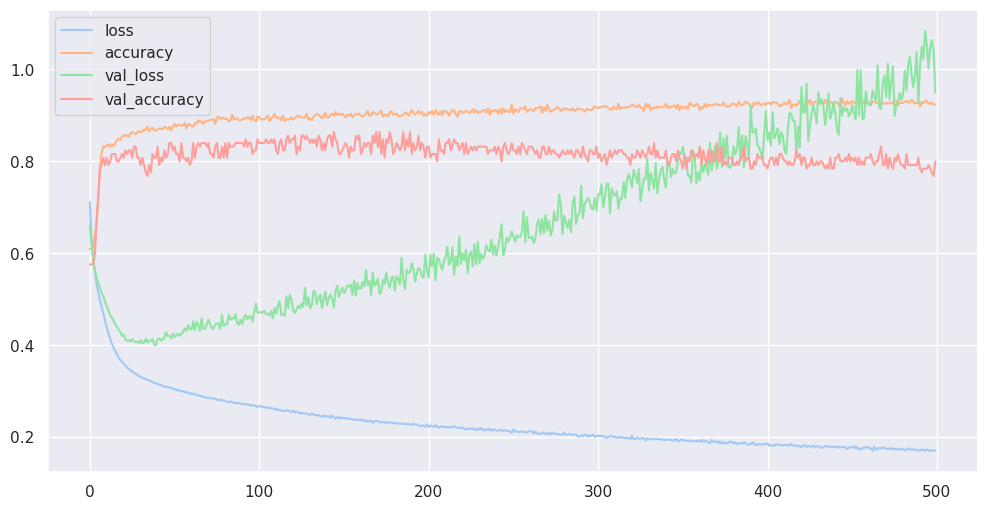

In [39]:
pd.DataFrame(hist.history).plot(figsize=PLOT_SIZE)

## Custom loss fucntion

In [40]:
X_train_s = minmax_scaler.fit_transform(X_train)
X_test_s = minmax_scaler.transform(X_test)

loss = -(y_true * log(y_pred) + (1-y_true) * log(1-y_pred)).

In [41]:
def calculate_binary_coef(y_true, y_pred):

    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    left = y_true * K.log(y_pred)
    right = (1-y_true) *  K.log(1-y_pred)
    return -(left + right)

    #return -K.mean(K.sum(y_true* K.log(y_pred)))

def custom_loss_binary():
    def binary(y_true, y_pred):
        return calculate_binary_coef(y_true, y_pred)
    return binary


def calculate_dice_coef(y_true, y_pred, smooth):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f))

def custom_loss_dice(smooth):
    def dice(y_true, y_pred):
        return -calculate_dice_coef(y_true, y_pred, smooth)
    return dice



In [42]:
model_binary = custom_loss_binary()
model_dice = custom_loss_dice(smooth=1e-5)

### custom_loss_binary

In [43]:
keras_model.compile(
        optimizer=tf.keras.optimizers.RMSprop(),
        loss=model_binary,
        metrics=["accuracy"]
    )

hist = keras_model.fit(X_train_s, y_train, 
                       validation_split=0.2,
                       epochs=4)

Epoch 1/4
16/16 [==============================] - 1s 13ms/step - loss: 0.9112 - accuracy: 0.8008 - val_loss: 0.7055 - val_accuracy: 0.8240
Epoch 2/4
16/16 [==============================] - 0s 5ms/step - loss: 0.6026 - accuracy: 0.7928 - val_loss: 0.6820 - val_accuracy: 0.8080
Epoch 3/4
16/16 [==============================] - 0s 6ms/step - loss: 0.5063 - accuracy: 0.7968 - val_loss: 0.6464 - val_accuracy: 0.7840
Epoch 4/4
16/16 [==============================] - 0s 5ms/step - loss: 0.4603 - accuracy: 0.8229 - val_loss: 0.5769 - val_accuracy: 0.7920


<AxesSubplot:>

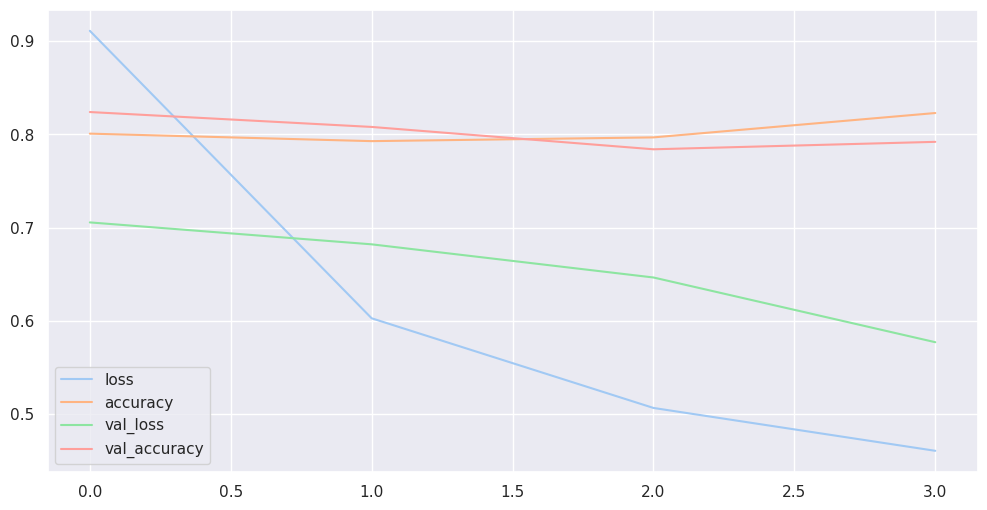

In [44]:
pd.DataFrame(hist.history).plot(figsize=PLOT_SIZE)

### custom_loss_dice

In [45]:
keras_model.compile(
        optimizer= tf.keras.optimizers.RMSprop(),
        loss=model_dice,
        metrics=["accuracy"]
    )

hist = keras_model.fit(X_train_s, y_train, 
                       validation_split=0.2,
                       epochs=4)

Epoch 1/4
16/16 [==============================] - 1s 15ms/step - loss: -0.7195 - accuracy: 0.8169 - val_loss: -0.7198 - val_accuracy: 0.8160
Epoch 2/4
16/16 [==============================] - 0s 5ms/step - loss: -0.7366 - accuracy: 0.8270 - val_loss: -0.7302 - val_accuracy: 0.8000
Epoch 3/4
16/16 [==============================] - 0s 5ms/step - loss: -0.7583 - accuracy: 0.8370 - val_loss: -0.7319 - val_accuracy: 0.8000
Epoch 4/4
16/16 [==============================] - 0s 5ms/step - loss: -0.7638 - accuracy: 0.8330 - val_loss: -0.7344 - val_accuracy: 0.8000


<AxesSubplot:>

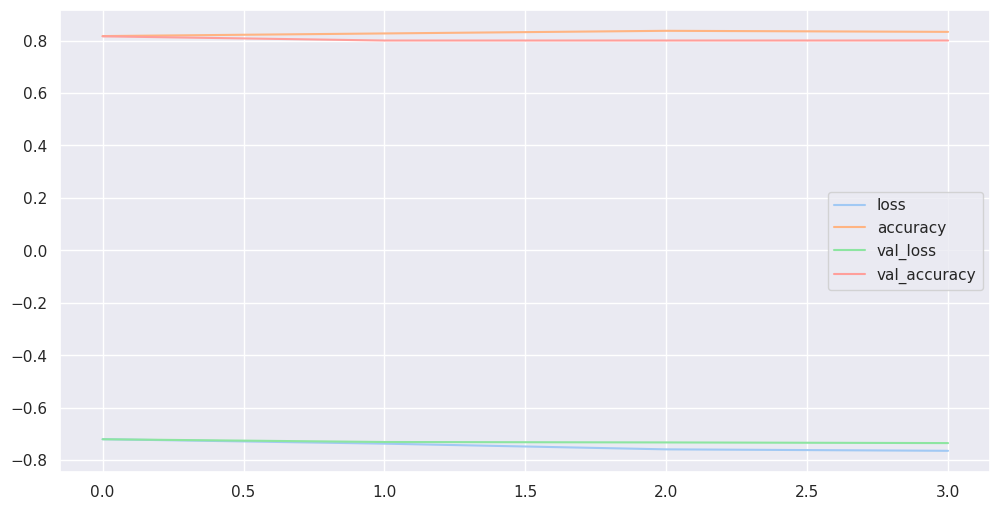

In [46]:
pd.DataFrame(hist.history).plot(figsize=PLOT_SIZE)

In [47]:
# Na osnovu zastupljenosti prezivelih i ne
def my_loss(y_true, y_pred):
            
    loss = K.abs(float(y_pred) - float(y_true))
    loss = loss *[0.38, 0.62]
    loss = K.sum(loss, axis=1)   
    return loss

In [48]:
keras_model.compile(
        optimizer= tf.keras.optimizers.RMSprop(),
        loss=my_loss,
        metrics=["accuracy"]
    )

hist = keras_model.fit(X_train_s, y_train, 
                       validation_split=0.2,
                       epochs=4)

Epoch 1/4
16/16 [==============================] - 1s 13ms/step - loss: 0.1782 - accuracy: 0.8390 - val_loss: 0.1894 - val_accuracy: 0.8240
Epoch 2/4
16/16 [==============================] - 0s 5ms/step - loss: 0.1707 - accuracy: 0.8410 - val_loss: 0.1829 - val_accuracy: 0.8320
Epoch 3/4
16/16 [==============================] - 0s 6ms/step - loss: 0.1651 - accuracy: 0.8431 - val_loss: 0.1823 - val_accuracy: 0.8320
Epoch 4/4
16/16 [==============================] - 0s 6ms/step - loss: 0.1623 - accuracy: 0.8531 - val_loss: 0.1799 - val_accuracy: 0.8320


<AxesSubplot:>

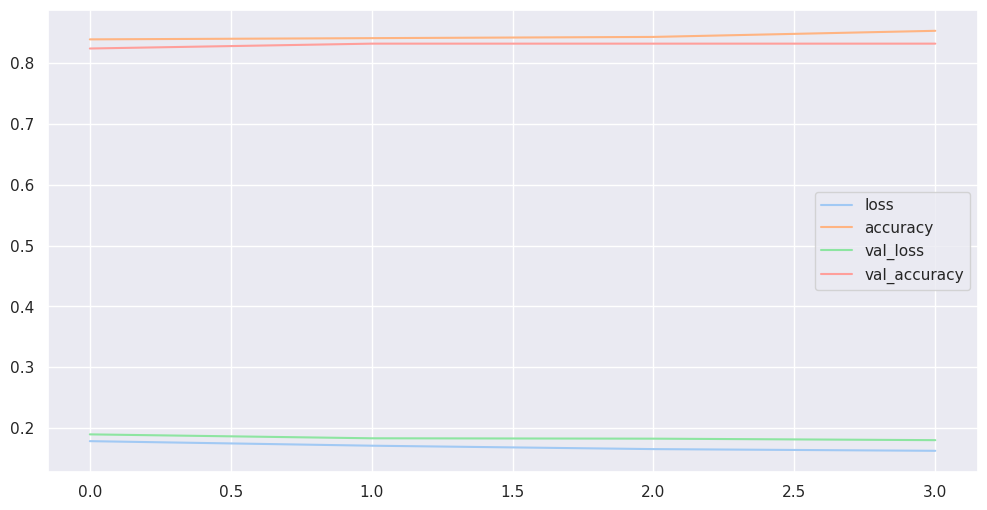

In [49]:
pd.DataFrame(hist.history).plot(figsize=PLOT_SIZE)